<a href="https://colab.research.google.com/github/ominivac/analise_integraSUS/blob/master/Analise_de_dados_do_IntegraSUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [16]:
import plotly
import numpy as np
import plotly.offline as py
from plotly.offline import plot, iplot
plotly.offline.init_notebook_mode(connected=True)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

In [1]:
import pandas as pd
df = pd.read_csv("/content/drive/My Drive/IntegraSUS/casos_coronavirus_2020_09_13.csv", low_memory=False)

#quantidade de registros
df.shape

(808318, 43)

In [2]:
# Preview dos dados 
df.head(3)

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus
0,0,877b53b5ce5a42ae2c559585ed63b0b1,NaN,CE,230030.0,ACOPIARA,NaN,FEMININO,38.0,NaN,2020-08-20 00:00:00.000,2020-08-31 08:51:50.000,2020-08-20 00:00:00.000,Negativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Parda,NaN,NaN,NaN
1,1,21b0d595ff06fe6735123f800789db65,NaN,CE,230440.0,FORTALEZA,GRANJA PORTUGAL,MASCULINO,40.0,2020-04-03 00:00:00.000,NaN,NaN,NaN,NaN,NaN,2020-03-27 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6999506,FORTALEZA
2,2,411ab7247fd8c191a7a178354dd94595,NaN,CE,230440.0,FORTALEZA,PANAMERICANO,MASCULINO,48.0,2020-04-03 00:00:00.000,NaN,NaN,NaN,NaN,NaN,2020-03-14 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6999506,FORTALEZA


In [3]:
# Tranformar as col. de data no tipo certo
df[["dataNotificacao","dataSolicitacaoExame","dataResultadoExame","dataColetaExame","dataInicioSintomas", "dataObito", "dataNotificacaoObito"]] =  df[["dataNotificacao","dataSolicitacaoExame","dataResultadoExame","dataColetaExame","dataInicioSintomas", "dataObito", "dataNotificacaoObito"]].apply(pd.to_datetime,  errors='coerce')

In [5]:
# Algumas colunas em brancos, contar para sexoPaciente
count = df["sexoPaciente"].isnull().sum()
print(count)

4164


In [6]:
 # Ver distribuição de atributos
df['racaCorPaciente'].unique().tolist()

['Parda', nan, 'Branca', 'Amarela', 'Preta', 'Ignorado', 'Indígena']

In [7]:
# Alterar onde for nan para Não Informado
df['racaCorPaciente'] = df['racaCorPaciente'].fillna('Não Informado')

In [8]:
df['evolucaoCasoSivep'].unique().tolist()

[nan, 'Óbito', 'Cura', 'Ignorado', '3']

In [9]:
df['tipoTesteExame'].unique().tolist()

['RT PCR',
 nan,
 'Eletroquimioluminescência',
 'Quimioluminescência',
 'ELISA',
 'Teste Rápido']

In [10]:
df['comorbidadePneumopatiaSivep'].unique().tolist()

[nan, 'Não', 'Sim', 'Ignorado']

In [11]:
df['comorbidadeDiabetesSivep'].unique().tolist()

[nan, 'Sim', 'Não', 'Ignorado']

In [12]:
df['comorbidadeCardiovascularSivep'].unique().tolist()

[nan, 'Sim', 'Não', 'Ignorado']

In [13]:
df['resultadoFinalExame'].unique().tolist()

['Negativo', nan, 'Positivo', 'Em Análise', 'Inconclusivo']

**Gerar nova coluna para faixa de idade**

In [14]:
bins= [0,9,19,39,59,79,120]
labels = ['0-9','10-19','20-39','40-59','60-79','80E+']
df['faixaIdade'] = pd.cut(df['idadePaciente'], bins=bins, labels=labels)
#df.head(5)

O que define o óbito? Segundo o IntegraSUS no estado do Ceará são 8686 desde o início

In [ ]:
# 01 df[df['obitoConfirmado'] == True] # 8693 rows 
# 02 df[df['dataObito'].notnull()] # 11018 rows 
# 03 df[df['evolucaoCasoSivep'] == 'Óbito'] 	# 9215 rows
# 04 df[ (df['obitoConfirmado'] == True) & (df['dataObito'].notnull())  ] # 8693 rows  a mais perto do numero oficial 3818 so de fortaleza
# 05 df[ (df['dataObito'].notnull() ) & (df['resultadoFinalExame'] == 'Positivo' )] # 8693 rows
# df[ (df['obitoConfirmado'] == True) & (df['dataObito'].notnull() ) & (df['resultadoFinalExame'] == 'Positivo')   ] #combinar 04 e 05 da o mesmo result. 8693 rows


In [17]:
# Como cada dia representa um óbito, criar nova coluna para cada registro somente HUM por registro 
df['qtObito'] = np.where(df['obitoConfirmado'] == True, 1, 0)
#df[df['qtObito'] == 1].head(3)

In [18]:
# Nova coluna para somar de casos confirmados SEM óbito
df['qtCasoConfirmadoSemObito'] = np.where(  ( df['resultadoFinalExame'] == 'Positivo')  & (df['dataObito'].isnull() ) , 1, 0) 
#df[df['qtCasoConfirmadoSemObito'] == 1].head(3)

**Criar novo dataset de casos confirmados SEM óbito**

In [19]:
df_confirmados = df[ (df['qtCasoConfirmadoSemObito'] == 1)  ]
#df_confirmados.head(3)


**Criar novo dataset de óbitos, baseado no df com menos colunas e somente cuja col obedece a True**

In [20]:
df_obitos = df[ df['obitoConfirmado'] == True]
#df_obitos.sort_values(by="dataObito").head(3)

In [21]:
# Criar campo para óbitos totais de um mesmo dia
df_obitos['qtdeObitoAcumuladoPorDia'] = df_obitos['qtObito'].groupby(df['dataObito']).transform('sum')
#df_obitos.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
# Criar campo para casos confirmados sem óbitos totais de um mesmo dia
df_confirmados['qtdeCasoAcumuladoPorDia'] = df_confirmados['qtCasoConfirmadoSemObito'].groupby(df['dataResultadoExame']).transform('sum')
df_confirmados.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,faixaIdade,qtObito,qtCasoConfirmadoSemObito,qtdeCasoAcumuladoPorDia
12,12,0e3a530d229e352cce8ba9669b14d051,BRASIL,CE,230440.0,FORTALEZA,JARDIM IRACEMA,FEMININO,85.0,2020-05-08,2020-05-08,2020-05-14 21:19:15,2020-05-07,Positivo,NaN,2020-05-03,NaT,3.158939e+11,Positivo,2020-05-06 00:00:00.000,NaN,NaN,Óbito,2020-05-10 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Parda,NaT,7274440,FORTALEZA,80E+,0,1,1.0
13,13,98a41cf3518911c90db853e0b0bf7b6a,BRASIL,CE,230440.0,FORTALEZA,SAO JOAO DO TAUAPE,MASCULINO,53.0,2020-04-07,2020-07-07,2020-07-08 22:55:42,2020-07-06,Positivo,NaN,2020-03-31,NaT,3.159405e+11,Positivo,2020-07-05 00:00:00.000,2020-07-05 00:00:00.000,2020-07-17 00:00:00.000,Cura,2020-07-24 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Parda,NaT,2561247,FORTALEZA,40-59,0,1,2.0
14,14,d7a40db527b034c49395540a3dd4db0a,BRASIL,CE,230220.0,BEBERIBE,PARIPUEIRA,FEMININO,40.0,2020-07-04,2020-07-07,2020-07-07 18:03:30,2020-07-06,Positivo,NaN,2020-07-01,NaT,3.159406e+11,Positivo,2020-07-05 00:00:00.000,2020-07-05 00:00:00.000,NaN,Cura,2020-07-14 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Não Informado,NaT,702407005553427,BEBERIBE,40-59,0,1,1.0


In [34]:
 # Método 01 para contagem de óbitos por dia
df_new = (pd.to_datetime(df_obitos['dataObito'])
       .dt.floor('d')
       .value_counts()
       .rename_axis('data_obito')
       .reset_index(name='count'))
print (df_new)

    data_obito  count
0   2020-05-11    156
1   2020-05-19    155
2   2020-05-17    152
3   2020-05-20    149
4   2020-05-21    148
..         ...    ...
166 2020-03-31      3
167 2020-03-26      3
168 2020-03-27      3
169 2020-03-28      2
170 2020-03-25      2

[171 rows x 2 columns]


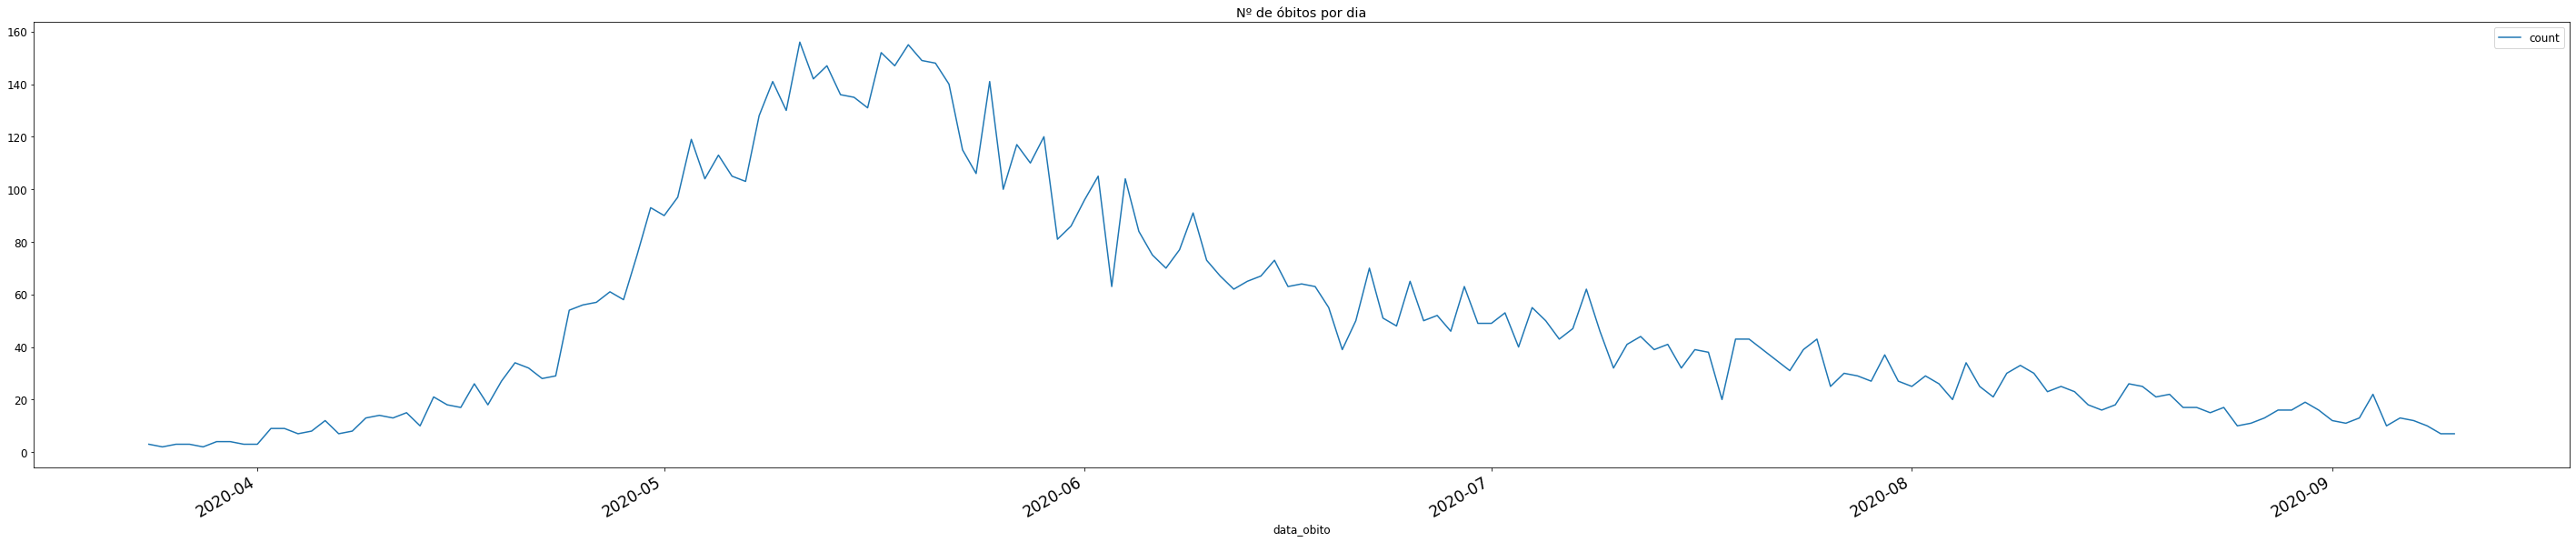

In [74]:
df_new.plot(x ='data_obito', y='count', kind = 'line', figsize= (50,10) , title ='Nº de óbitos por dia')
plt.tick_params(axis='x', labelsize=17)
plt.show()

***Gerar novo dataset de óbitos somente para plotagem***

In [41]:
 # Método 02 para contagem de óbitos por dia
# um novo dataset para plotagem
new_df_obit = df_obitos.groupby(['dataObito'])['qtObito'].sum().to_frame('total').reset_index()
new_df_obit

,dataObito,total
0,2020-03-24,3
1,2020-03-25,2
2,2020-03-26,3
3,2020-03-27,3
4,2020-03-28,2
...,...,...
166,2020-09-06,13
167,2020-09-07,12
168,2020-09-08,10
169,2020-09-09,7


In [30]:
# Teste
df_new[df_new['data_obito'] == '2020-09-10']

,data_obito,count
160,2020-09-10,7


In [42]:
new_df_obit['totalAcumulado'] = new_df_obit['total'].cumsum()
new_df_obit

,dataObito,total,totalAcumulado
0,2020-03-24,3,3
1,2020-03-25,2,5
2,2020-03-26,3,8
3,2020-03-27,3,11
4,2020-03-28,2,13
...,...,...,...
166,2020-09-06,13,8657
167,2020-09-07,12,8669
168,2020-09-08,10,8679
169,2020-09-09,7,8686


***Gerar novo dataset de casos confirmados somente para plotagem***

In [43]:
new_df_casos_confirm = df_confirmados.groupby(['dataResultadoExame'])['qtCasoConfirmadoSemObito'].sum().to_frame('total').reset_index()
new_df_casos_confirm.head

<bound method NDFrame.head of        dataResultadoExame  total
0     2020-01-01 00:00:00      1
1     2020-01-02 00:00:00      2
2     2020-01-07 00:00:00      1
3     2020-01-09 00:00:00      1
4     2020-01-11 00:00:00      1
...                   ...    ...
39229 2020-09-13 11:46:25      1
39230 2020-09-13 11:46:42      1
39231 2020-09-13 11:47:13      1
39232 2020-09-13 11:47:36      1
39233 2020-09-13 11:50:50      1

[39234 rows x 2 columns]>

In [44]:
new_df_casos_confirm['totalAcumulado'] = new_df_casos_confirm['total'].cumsum()
new_df_casos_confirm

,dataResultadoExame,total,totalAcumulado
0,2020-01-01 00:00:00,1,1
1,2020-01-02 00:00:00,2,3
2,2020-01-07 00:00:00,1,4
3,2020-01-09 00:00:00,1,5
4,2020-01-11 00:00:00,1,6
...,...,...,...
39229,2020-09-13 11:46:25,1,235575
39230,2020-09-13 11:46:42,1,235576
39231,2020-09-13 11:47:13,1,235577
39232,2020-09-13 11:47:36,1,235578


**Gráfico 01 - Curva acumulado de óbitos por período**



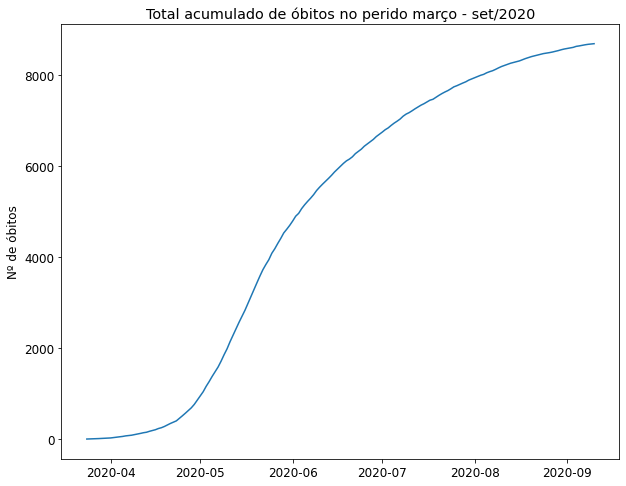

In [46]:
plt.plot( new_df_obit['dataObito'], new_df_obit['totalAcumulado'] )
plt.title('Total acumulado de óbitos no perido março - set/2020')
matplotlib.rcParams.update({'font.size': 12})
plt.rcParams["figure.figsize"] = (10,8)
plt.ylabel('Nº de óbitos');
plt.show()

**Gráfico 02 - Curva acumulado de casos confirmados acumulados  por período**

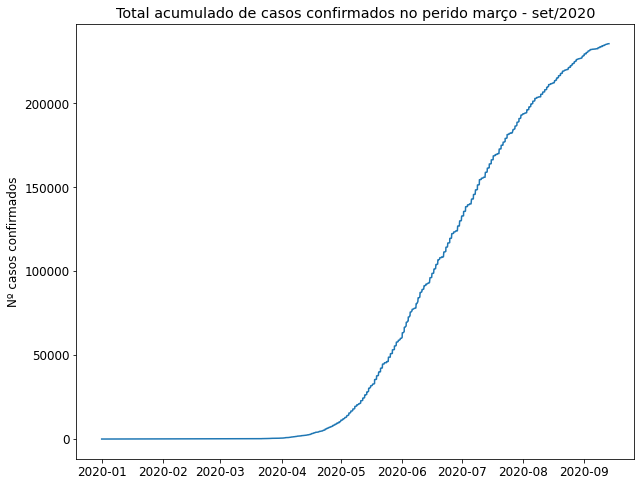

In [47]:
plt.plot( new_df_casos_confirm['dataResultadoExame'], new_df_casos_confirm['totalAcumulado'] )
plt.title('Total acumulado de casos confirmados no perido março - set/2020')
matplotlib.rcParams.update({'font.size': 12})
plt.rcParams["figure.figsize"] = (10,8)
plt.ylabel('Nº casos confirmados');
plt.show()

In [48]:
group_obito_data = df_obitos.groupby('dataObito').qtObito.sum()
group_obito_data

dataObito
2020-03-24     3
2020-03-25     2
2020-03-26     3
2020-03-27     3
2020-03-28     2
              ..
2020-09-06    13
2020-09-07    12
2020-09-08    10
2020-09-09     7
2020-09-10     7
Name: qtObito, Length: 171, dtype: int64

In [ ]:
# Cálculo para média móvel com janela de 7 dias
df_obitos['mediaMovelObito'] = df_obitos.qtObito.rolling(window=7).mean()

df_confirmados['mediaMovelCasos'] = df_confirmados.qtCasoConfirmadoSemObito.rolling(window=7).mean()

**Gráfico 03 - Total de óbitos por dia no período Março - Setembro 2020 (Resumido )**

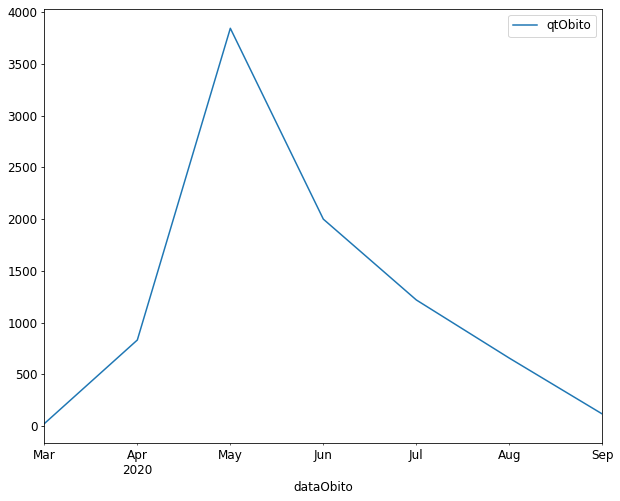

In [50]:
  # agrupar por mes a qtde de obitos e plotar
df_obitos.groupby(pd.Grouper(key='dataObito',freq='M')).agg({'qtObito':'sum'}).plot(figsize=(10, 8))

In [51]:
group_acumulado_ob_dia = df_obitos.groupby('dataObito')
group_acumulado_ob_dia['dataObito'].count()

dataObito
2020-03-24     3
2020-03-25     2
2020-03-26     3
2020-03-27     3
2020-03-28     2
              ..
2020-09-06    13
2020-09-07    12
2020-09-08    10
2020-09-09     7
2020-09-10     7
Name: dataObito, Length: 171, dtype: int64

**Gráfico 04 - Total de óbitos por dia no período Março - Setembro 2020 (Detalhado)**

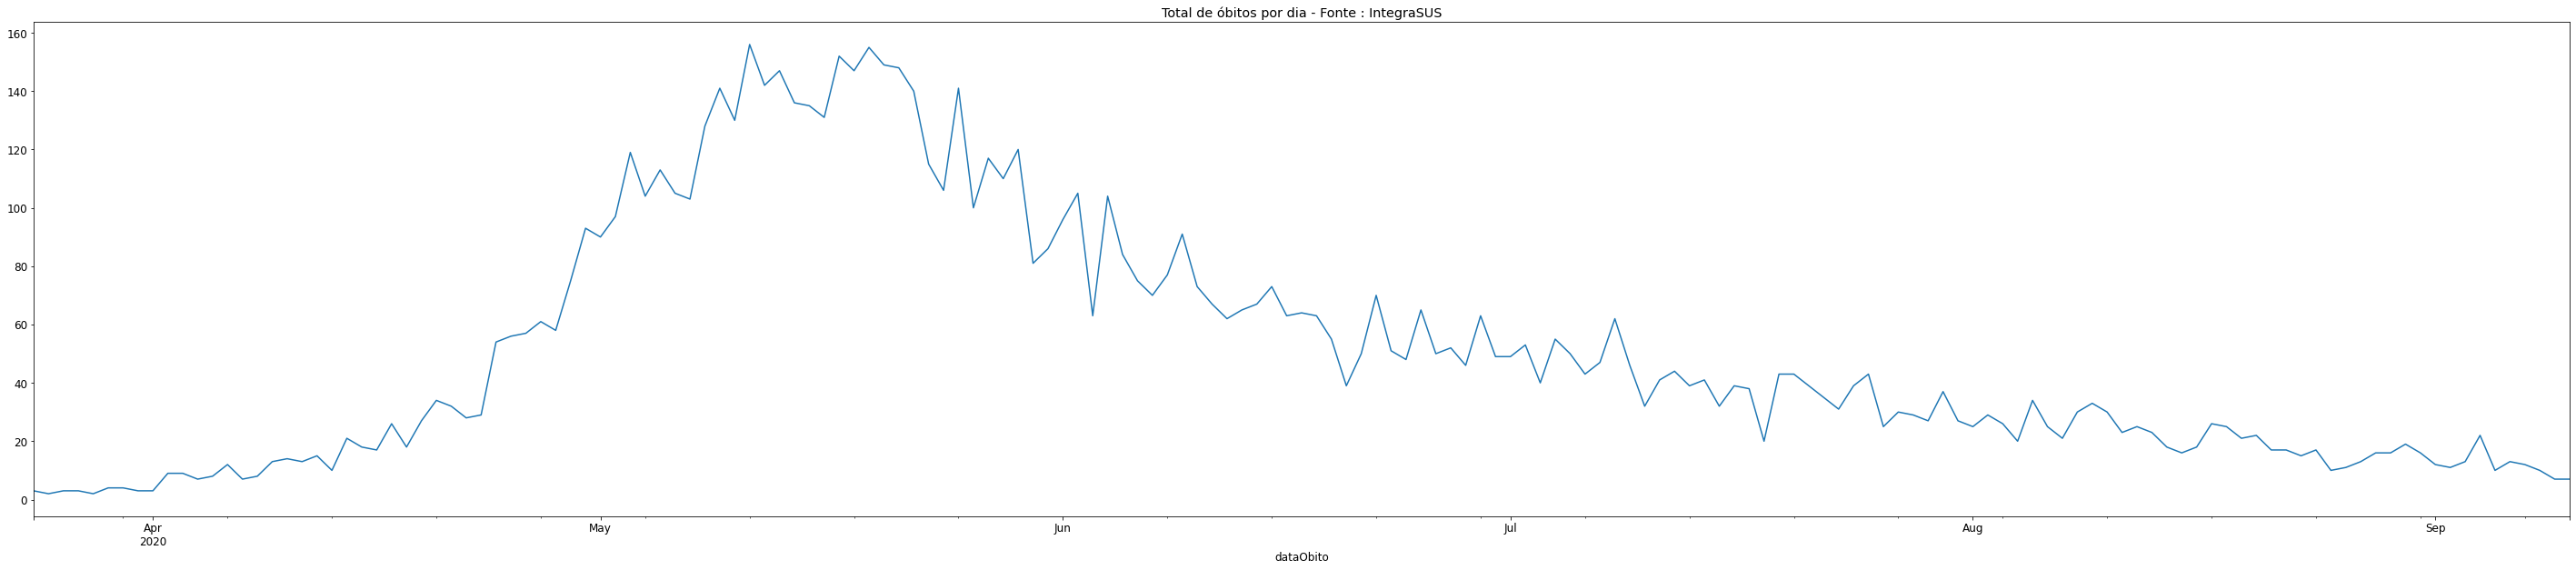

In [52]:
gr_grafico_acumulado_ob_dia = group_acumulado_ob_dia['dataObito'].count()
gr_grafico_acumulado_ob_dia.plot( figsize=(50,10), title = 'Total de óbitos por dia - Fonte : IntegraSUS')

**Gráfico 04 - Total de novos casos por dia no período Março - Setembro 2020 (Resumido)**

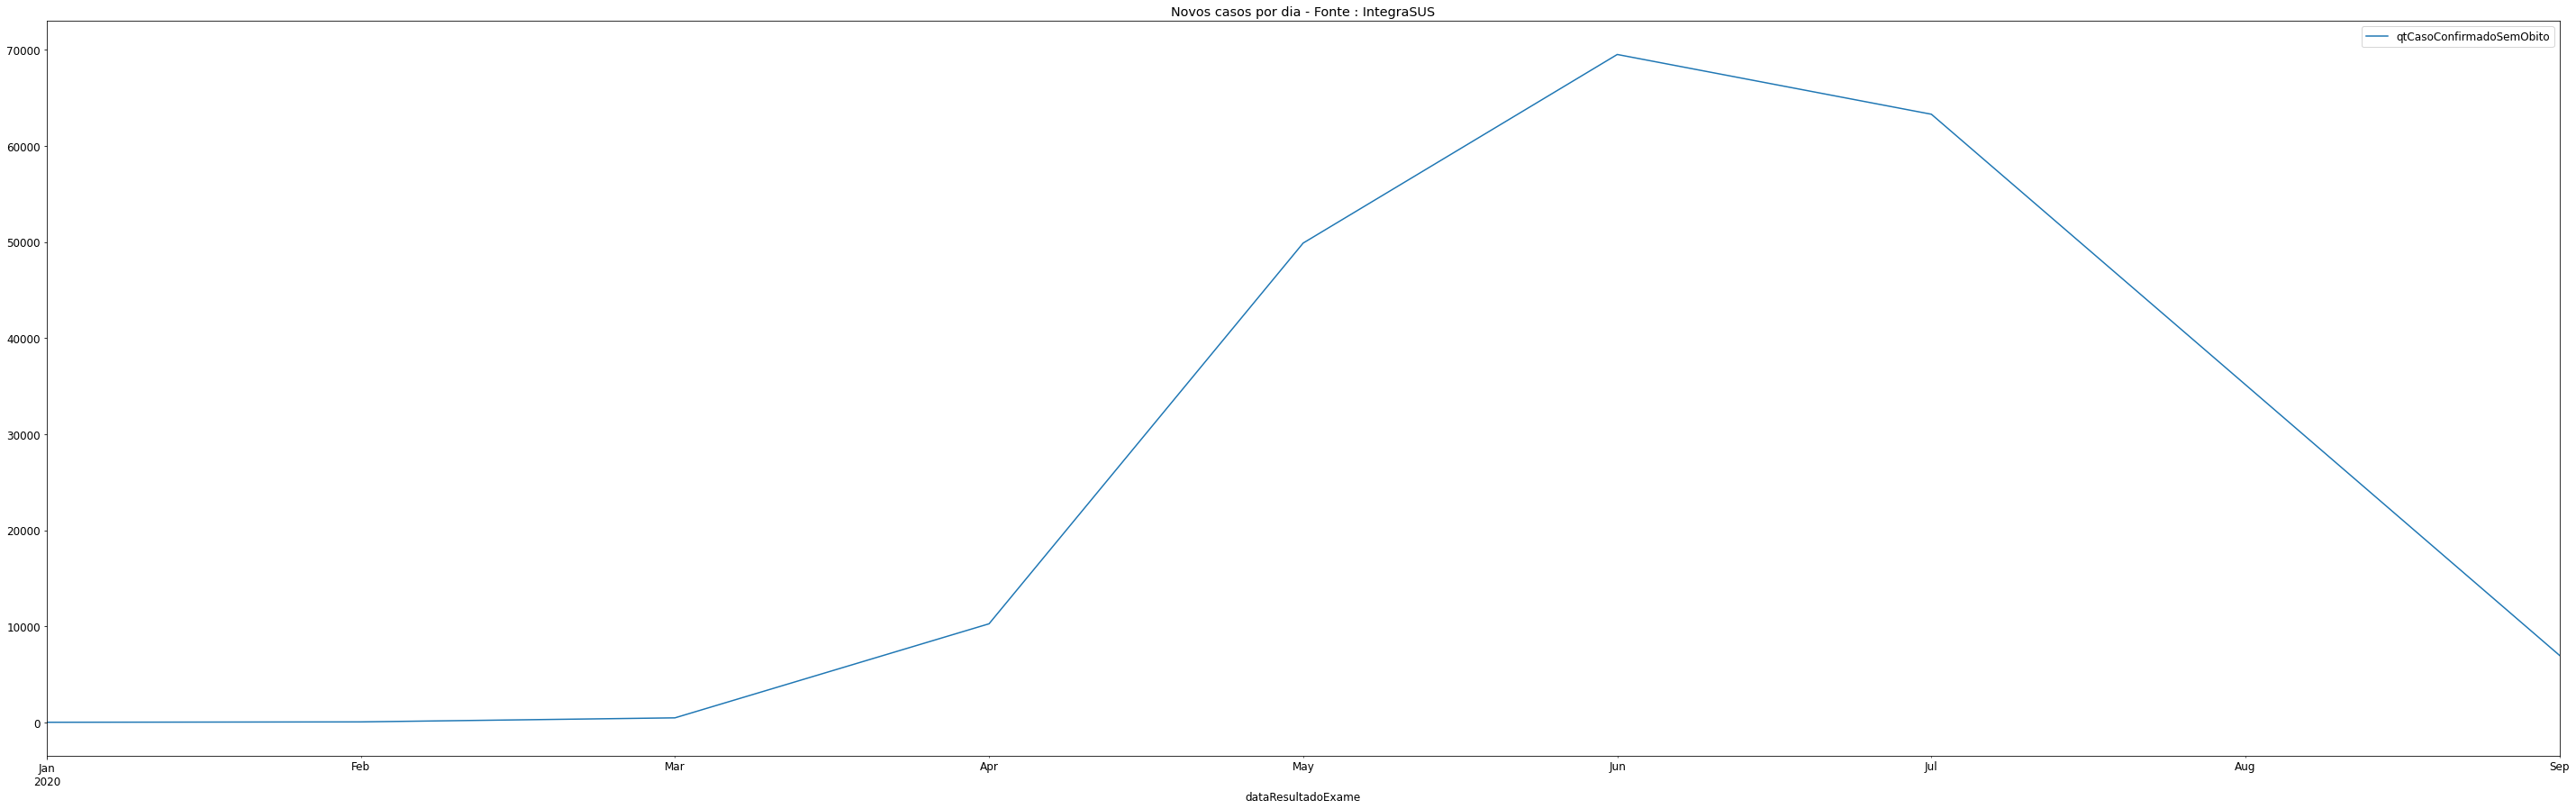

In [53]:
  # agrupar por mes a qtde de casos confirmados SEM óbito e plotar
df_confirmados.groupby(pd.Grouper(key='dataResultadoExame',freq='M')).agg({'qtCasoConfirmadoSemObito':'sum'}).plot(figsize=(50, 15) ,title = 'Novos casos por dia - Fonte : IntegraSUS')

**Preparar para plotagem somente de casos confirmados**

In [54]:
group_confirmados = df_confirmados.groupby(by=df_confirmados['dataResultadoExame'].dt.date).count()
df_confir_graf = group_confirmados['dataResultadoExame']

**Gráfico 04 - Total de novos por dia no período Março - Setembro 2020 Histogram**

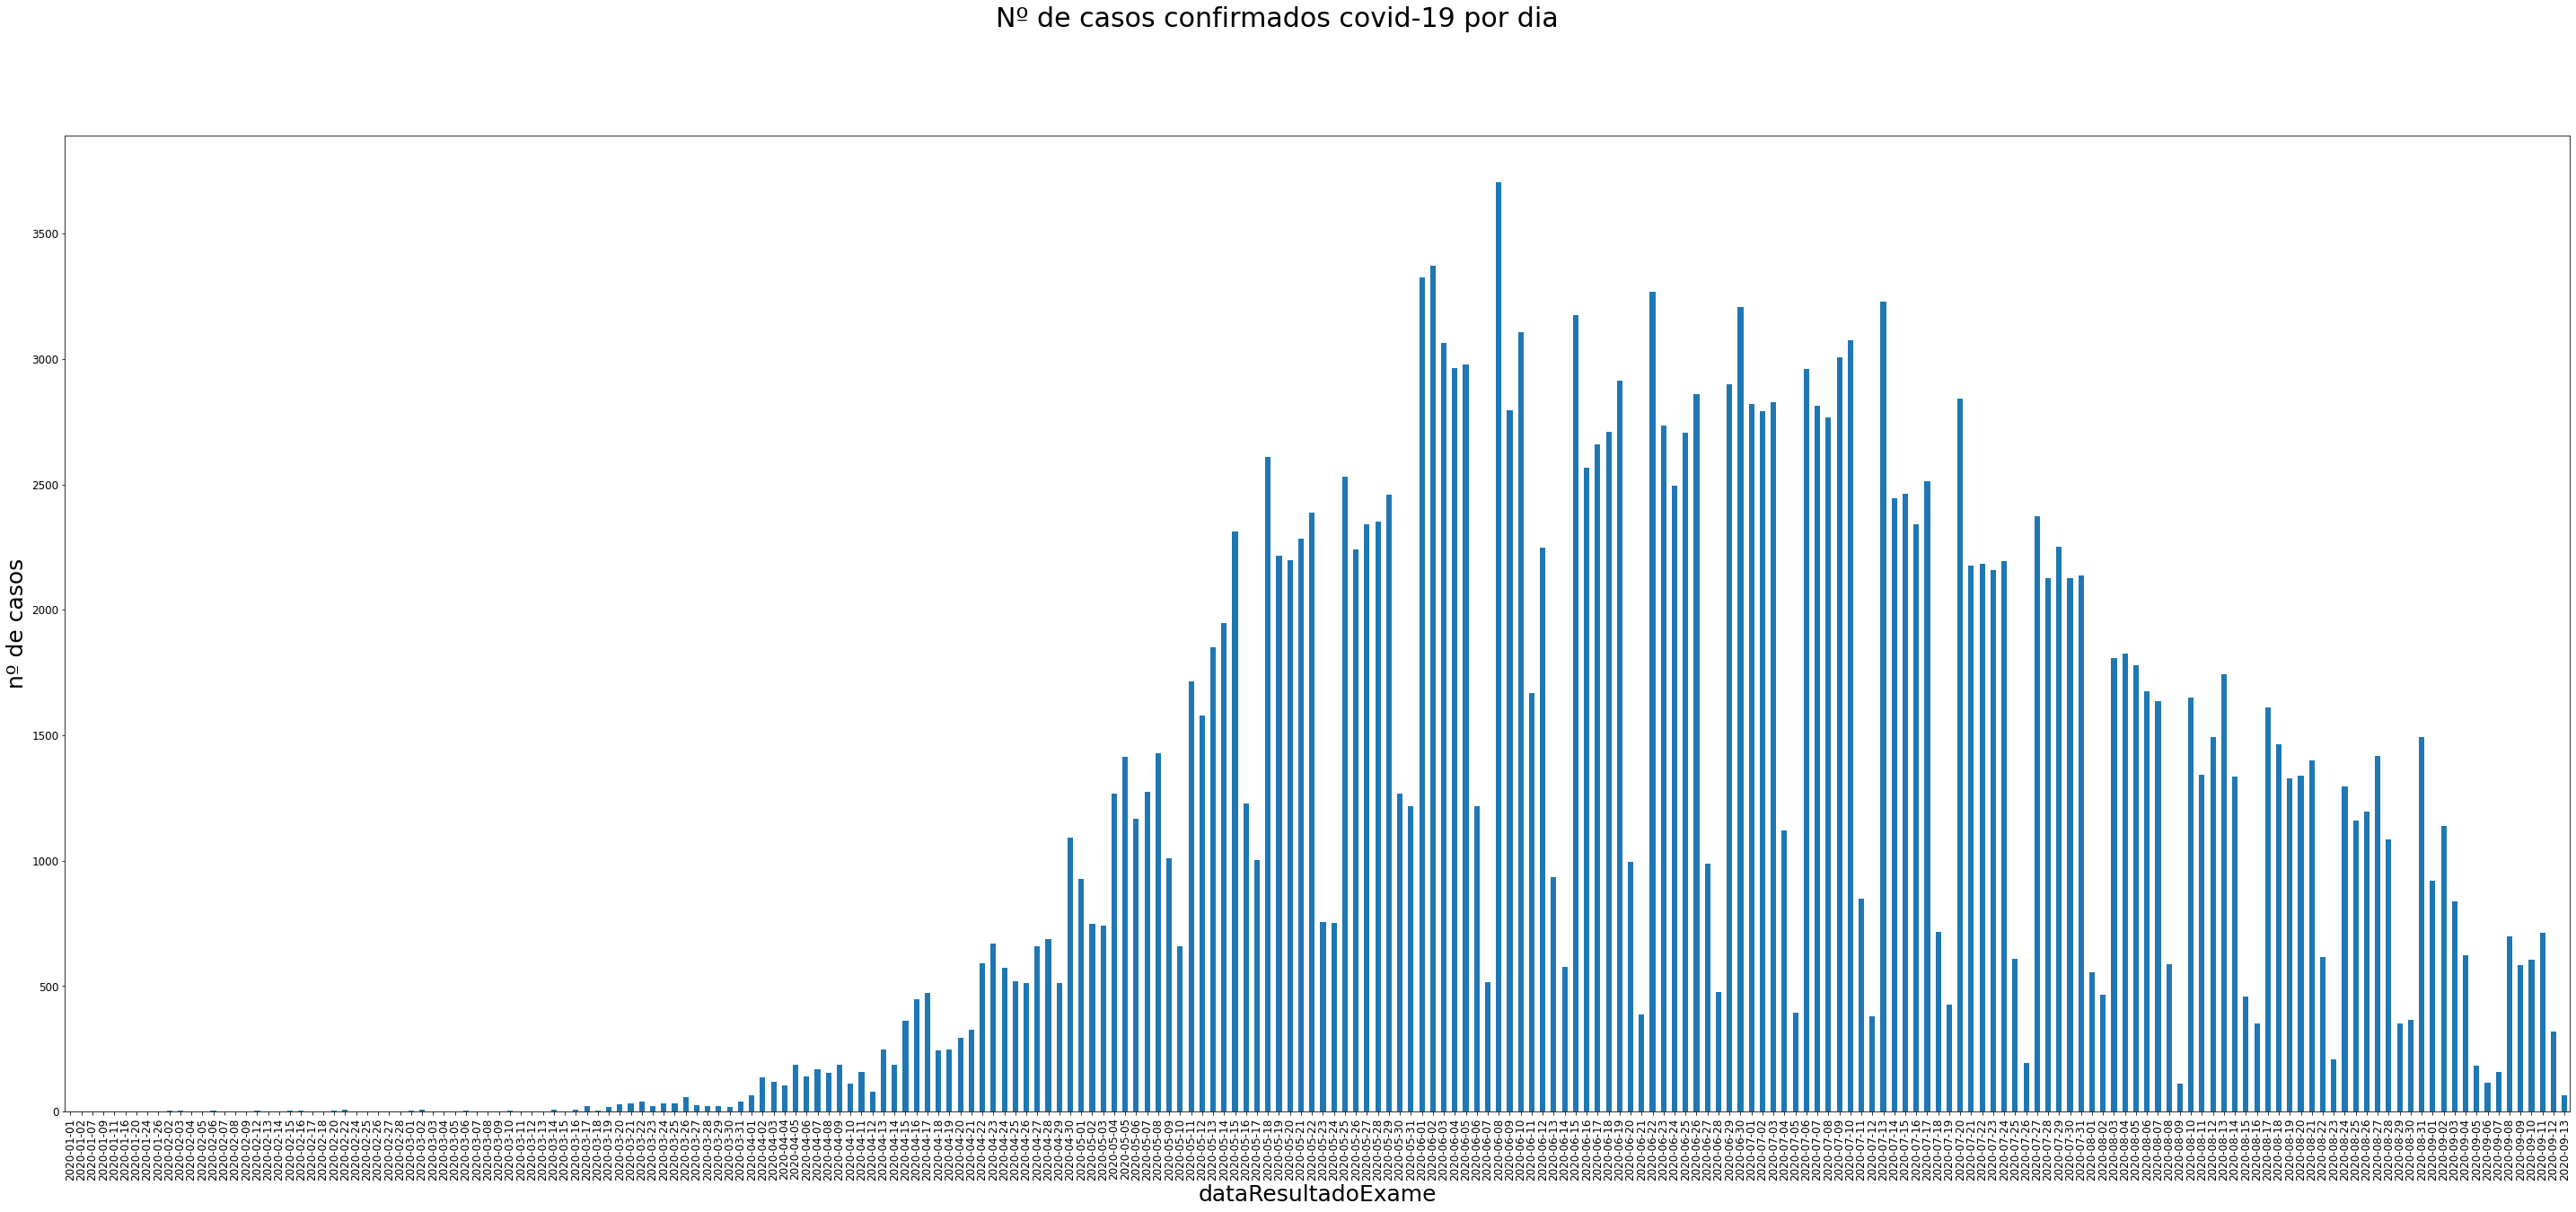

In [57]:
# Plotagem fica muito grande, tirar pela média movel de novos casos
plt.xlabel('Data resultado do exame', fontsize=25) 
plt.ylabel('nº de casos', fontsize=25)
#plt.tick_params(axis='x', labelsize=17)
plt.suptitle('Nº de casos confirmados covid-19 por dia', fontsize=30)

df_confir_graf.plot(figsize=(50, 20), kind='bar')

**Preparar para plotagem somente dos óbitos**


In [ ]:
group_obito = df_obitos.groupby(by=df_obitos['dataObito'].dt.date).count()
# group_obito.

**Gráfico 05 - Total de novos óbitos por dia no período Março - Setembro 2020 (Histogram)**

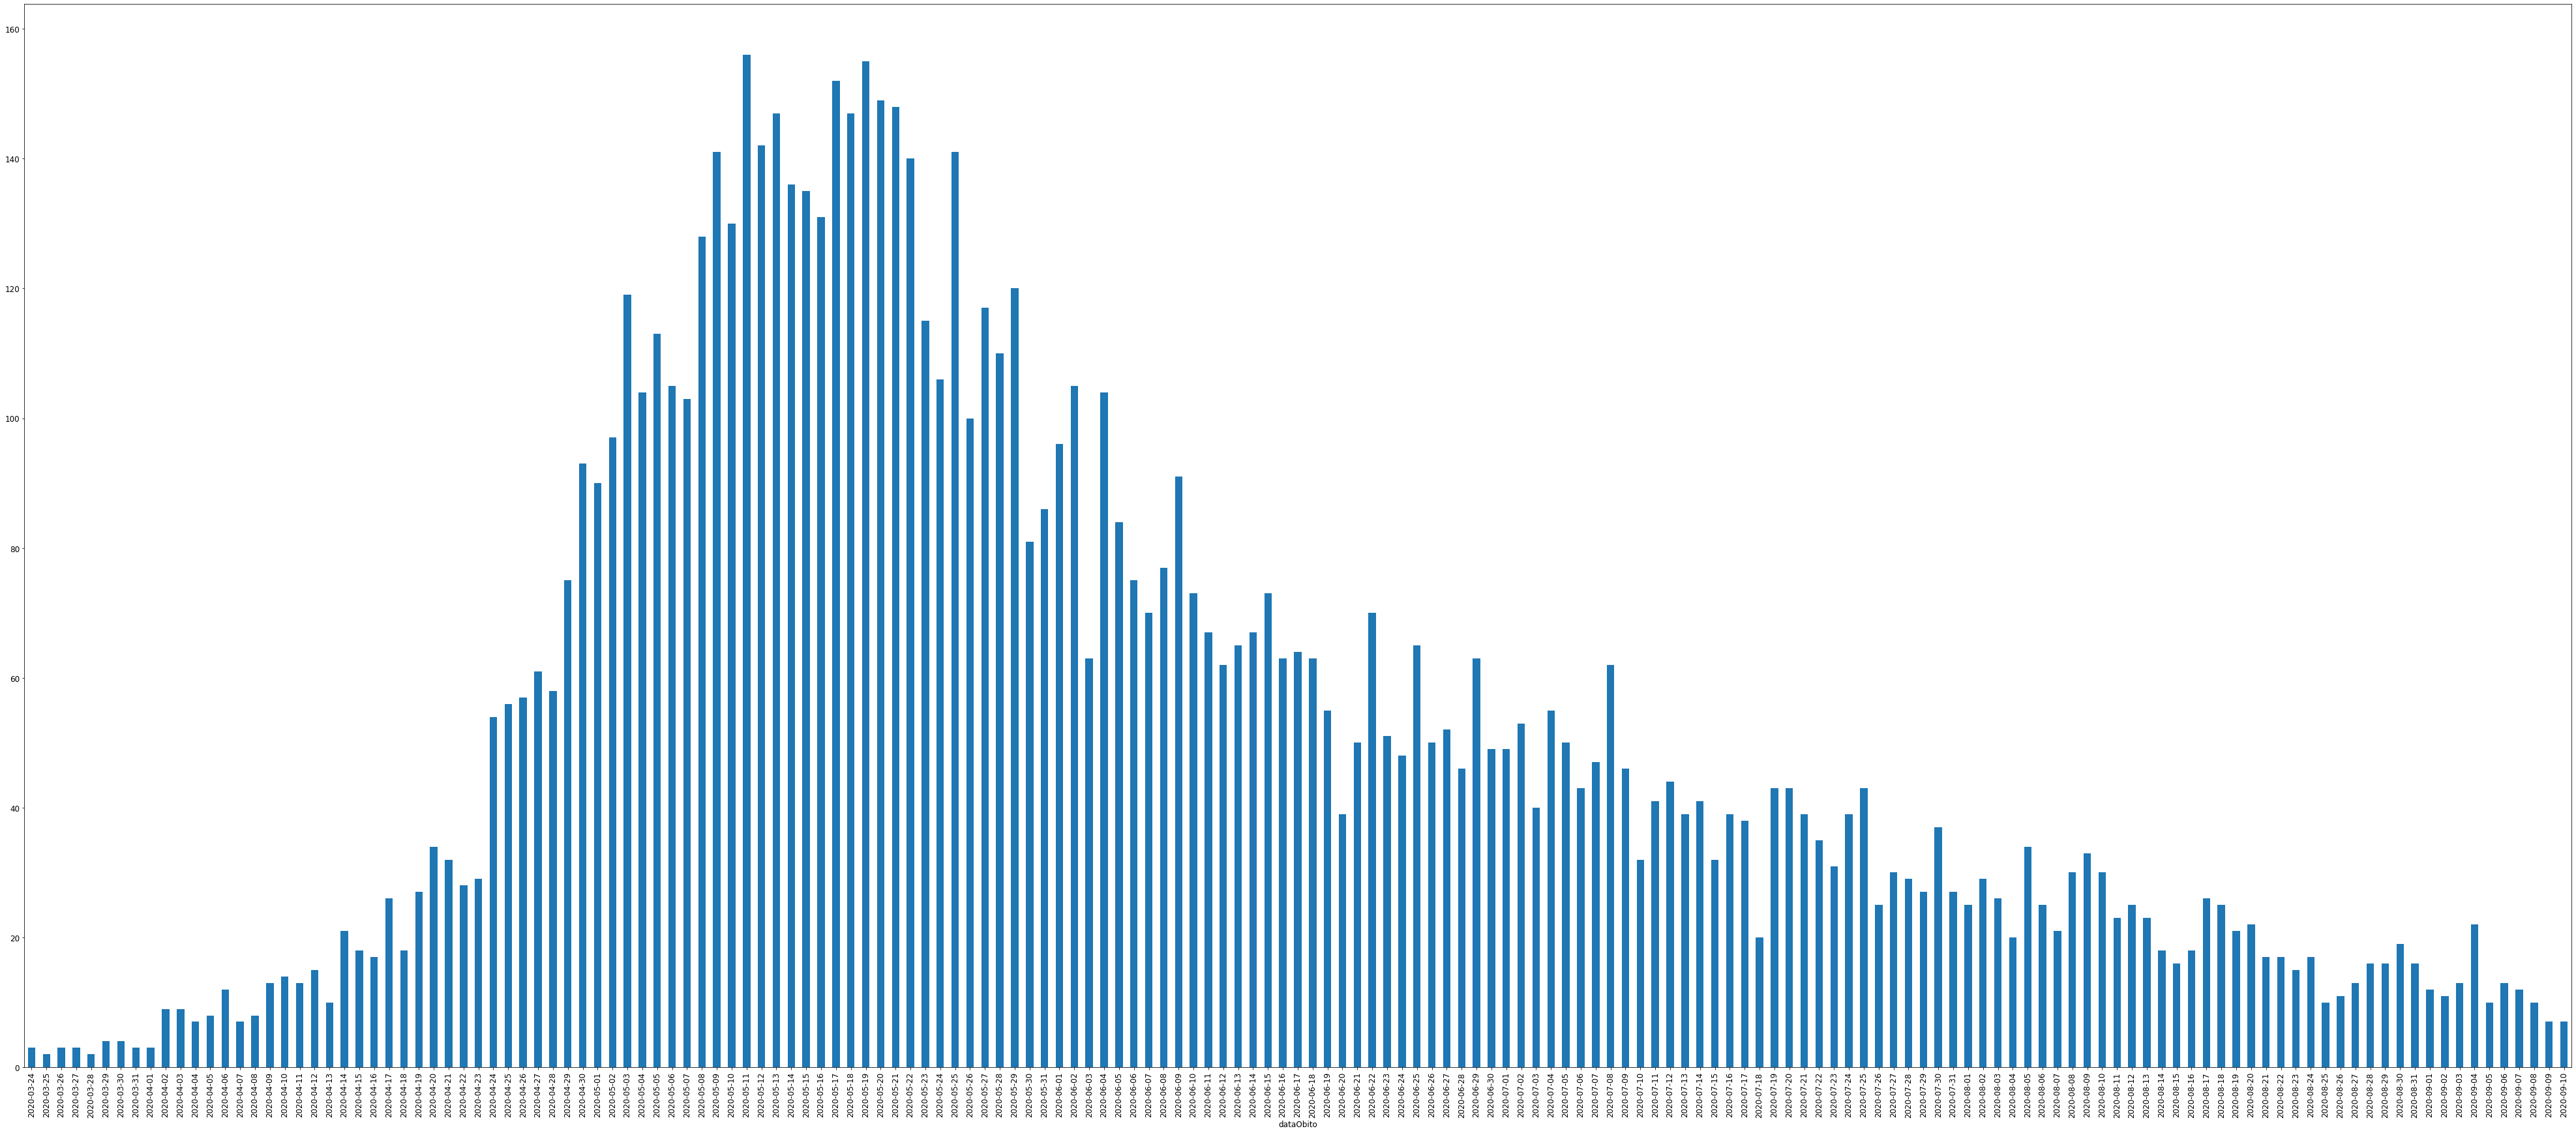

In [59]:
df_ob_graf = group_obito['dataObito']
df_ob_graf.plot(figsize=(70, 30), kind='bar')

In [60]:
group_faixa_idade_obito = df_obitos.groupby(by=df_obitos['faixaIdade']).count()
group_faixa_idade_obito

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,qtdeObitoAcumuladoPorDia,mediaMovelObito
faixaIdade,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-9,16,16,11,16,16,16,13,16,16,13,9,11,16,16,16,16,16,11,10,11,2,1,8,8,2,2,2,2,2,2,4,2,3,2,2,0,0,16,16,16,16,4,5,16,16,16,16
10-19,29,29,20,29,29,29,26,29,29,20,16,18,29,29,29,25,29,17,16,15,10,3,17,17,5,5,5,5,5,5,7,5,5,5,5,0,0,29,29,29,29,12,14,29,29,29,29
20-39,334,334,288,334,333,334,287,334,334,276,180,235,318,334,334,304,334,261,249,236,132,63,243,235,73,87,72,72,76,95,73,71,78,75,83,0,0,334,334,334,334,110,149,334,334,334,334
40-59,1418,1418,1202,1416,1416,1418,1211,1418,1418,1182,843,1030,1340,1418,1418,1287,1418,1084,1029,937,466,266,1032,1012,343,483,357,359,361,523,361,367,370,367,381,0,0,1418,1414,1418,1418,465,627,1418,1418,1418,1418
60-79,3769,3769,3186,3769,3768,3768,3267,3769,3769,3151,2302,2845,3568,3769,3769,3411,3769,2863,2717,2447,1133,614,2718,2650,972,1546,993,988,983,1532,1028,1014,994,1019,990,0,0,3769,3763,3769,3769,1358,1748,3769,3769,3769,3766
80E+,2740,2740,2292,2740,2740,2740,2292,2740,2740,2304,1646,2076,2600,2740,2740,2510,2740,2088,1982,1670,601,271,1993,1955,653,1154,653,653,656,984,739,680,649,672,646,0,0,2740,2731,2740,2740,944,1189,2740,2740,2740,2737


**Gráfico 06 - Contagem de óbitos por faixa de idade no período Março - Setembro 2020 (Resumido)**

In [61]:
counts_obitos_faixa_idade = df_obitos.groupby(['faixaIdade', 'sexoPaciente']).faixaIdade.count().unstack()
counts_obitos_faixa_idade

sexoPaciente,FEMININO,MASCULINO
faixaIdade,,
0-9,9,7
10-19,12,17
20-39,136,198
40-59,520,898
60-79,1562,2207
80E+,1276,1464


**Contagem de óbitos por faixa de idade no período Março - Setembro 2020 (Histogram)**

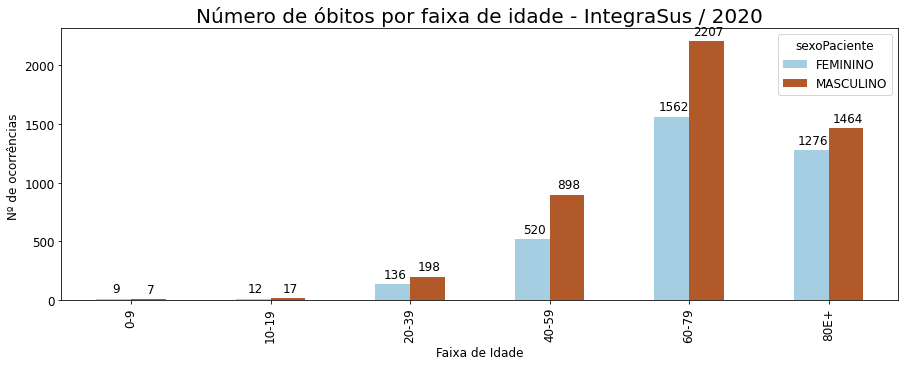

In [62]:
ax = counts_obitos_faixa_idade.plot(kind='bar',stacked = False, colormap = 'Paired', figsize=(15, 5) )

for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=0).astype(np.int64), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(2, 10), textcoords='offset points')

plt.xlabel ('Faixa de Idade')
plt.ylabel ('Nº de ocorrências ')
plt.title('Número de óbitos por faixa de idade - IntegraSus / 2020',fontsize=20)
plt.show()

**Conferência para o gráfico acima**


In [63]:
group_faixa_idade_obito = df_obitos.groupby('faixaIdade')
group_faixa_idade_obito['faixaIdade'].count()

faixaIdade
0-9        16
10-19      29
20-39     334
40-59    1418
60-79    3769
80E+     2740
Name: faixaIdade, dtype: int64

**Gráfico 07 - Ocorrências de óbito por sexo do paciente (Histogram)**

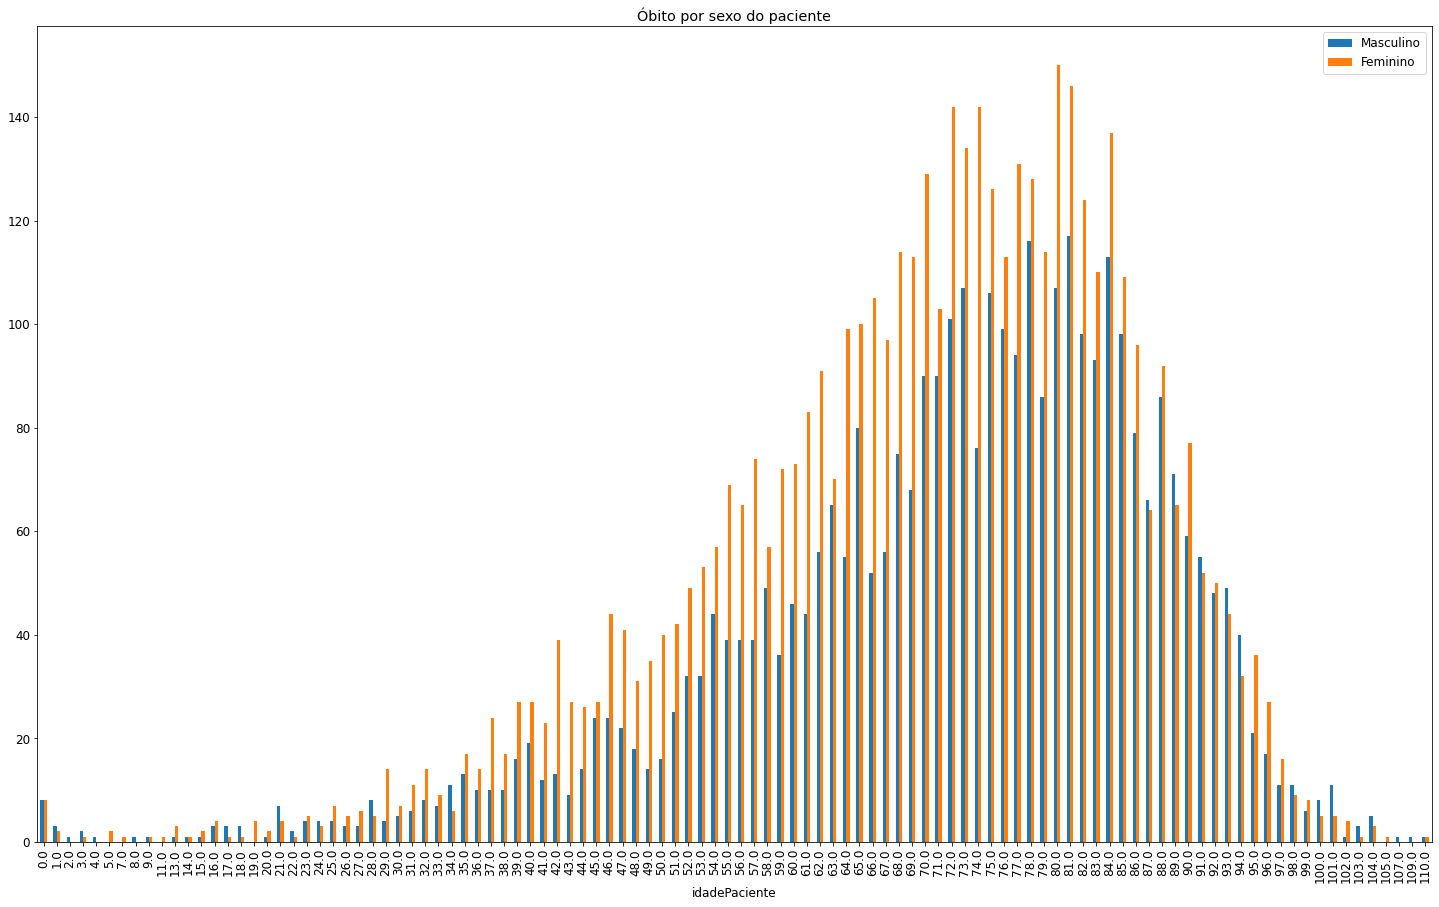

In [64]:
obito_by_sex = df_obitos.groupby(['idadePaciente', 'sexoPaciente']).size().unstack('sexoPaciente')
obito_by_sex.columns = ['Masculino', 'Feminino']
obito_by_sex.plot.bar(title='Óbito por sexo do paciente', figsize=(25,15) )

**Gráfico 08 - Distribuição de óbitos por raça/cor do paciente (Pie)**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1bb326080>,
      dtype=object)

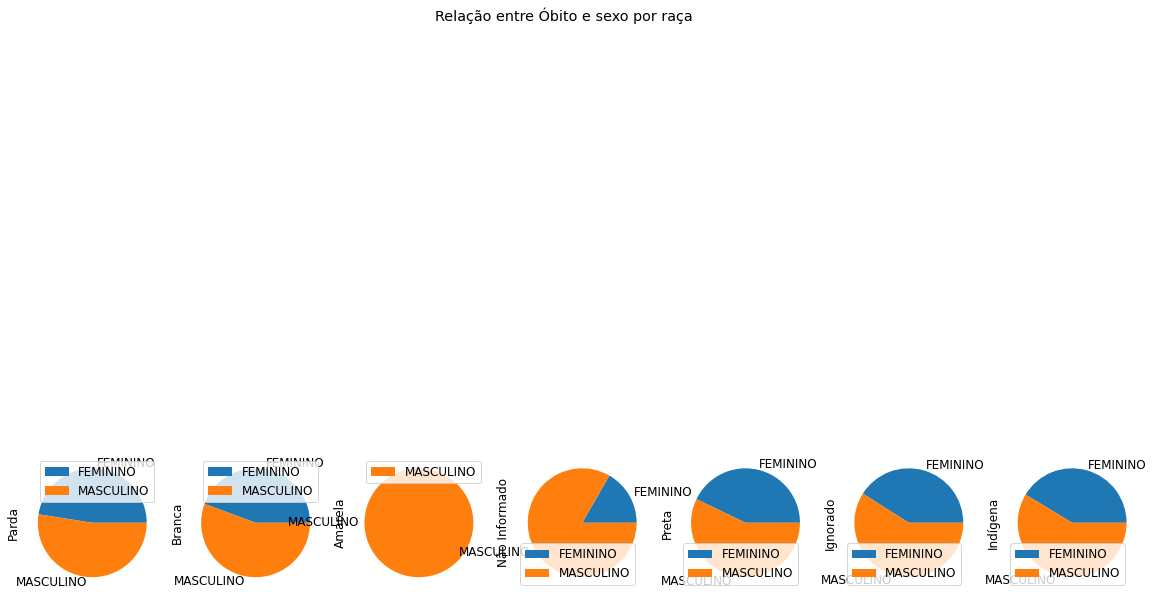

In [65]:
obito_by_sexo = df_obitos.groupby([ 'sexoPaciente', 'racaCorPaciente']).size().unstack('racaCorPaciente')
obito_by_sexo.columns =  ['Parda','Branca','Amarela', 'Não Informado','Preta','Ignorado','Indígena']


obito_by_sexo.plot.pie(title='Relação entre Óbito e sexo por raça', figsize=(20,15) , subplots = True  )

**Gráficos 9 - Distribuição de óbitos por faixa de idade do paciente(histogram)**

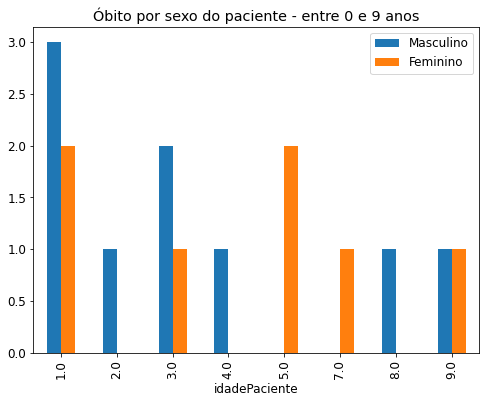

In [66]:
df_obit_faixa1 = df_obitos.loc[ (df_obitos['faixaIdade'] == '0-9')]
df_obit_plot_faixa1 = df_obit_faixa1.groupby(['idadePaciente', 'sexoPaciente']).size().unstack('sexoPaciente')
df_obit_plot_faixa1.columns = ['Masculino', 'Feminino']
df_obit_plot_faixa1.plot.bar(title='Óbito por sexo do paciente - entre 0 e 9 anos', figsize=(8,6) )

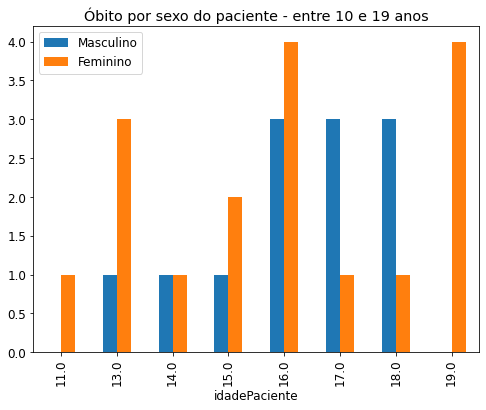

In [67]:
df_obit_faixa2 = df_obitos.loc[ (df_obitos['faixaIdade'] == '10-19')]
df_obit_plot_faixa2 = df_obit_faixa2.groupby(['idadePaciente', 'sexoPaciente']).size().unstack('sexoPaciente')
df_obit_plot_faixa2.columns = ['Masculino', 'Feminino']
df_obit_plot_faixa2.plot.bar(title='Óbito por sexo do paciente - entre 10 e 19 anos', figsize=(8,6) )

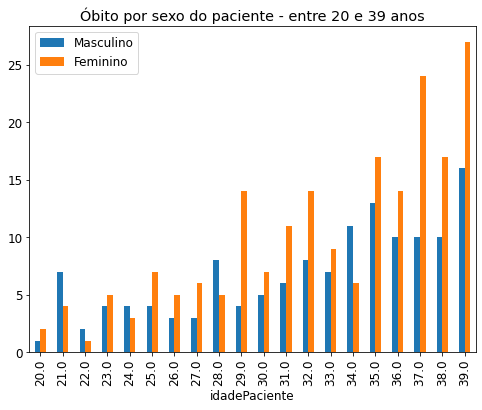

In [68]:
df_obit_faixa3 = df_obitos.loc[ (df_obitos['faixaIdade'] == '20-39')]
df_obit_plot_faixa3 = df_obit_faixa3.groupby(['idadePaciente', 'sexoPaciente']).size().unstack('sexoPaciente')
df_obit_plot_faixa3.columns = ['Masculino', 'Feminino']
df_obit_plot_faixa3.plot.bar(title='Óbito por sexo do paciente - entre 20 e 39 anos', figsize=(8,6) )

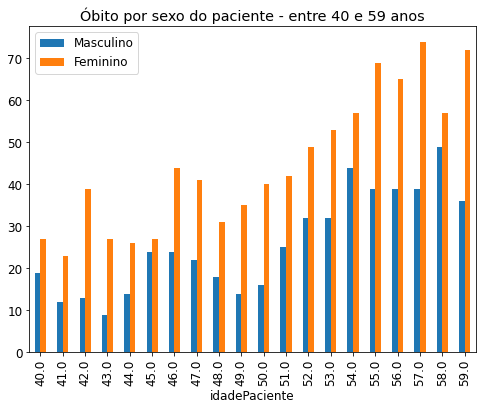

In [69]:
df_obit_faixa4 = df_obitos.loc[ (df_obitos['faixaIdade'] == '40-59')]
df_obit_plot_faixa4 = df_obit_faixa4.groupby(['idadePaciente', 'sexoPaciente']).size().unstack('sexoPaciente')
df_obit_plot_faixa4.columns = ['Masculino', 'Feminino']
df_obit_plot_faixa4.plot.bar(title='Óbito por sexo do paciente - entre 40 e 59 anos', figsize=(8,6) )

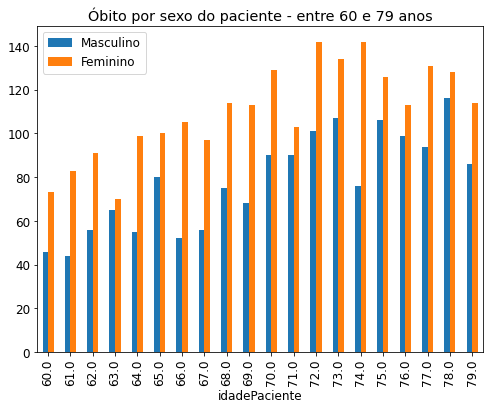

In [70]:
df_obit_faixa5 = df_obitos.loc[ (df_obitos['faixaIdade'] == '60-79')]
df_obit_plot_faixa5 = df_obit_faixa5.groupby(['idadePaciente', 'sexoPaciente']).size().unstack('sexoPaciente')
df_obit_plot_faixa5.columns = ['Masculino', 'Feminino']
df_obit_plot_faixa5.plot.bar(title='Óbito por sexo do paciente - entre 60 e 79 anos', figsize=(8,6) )

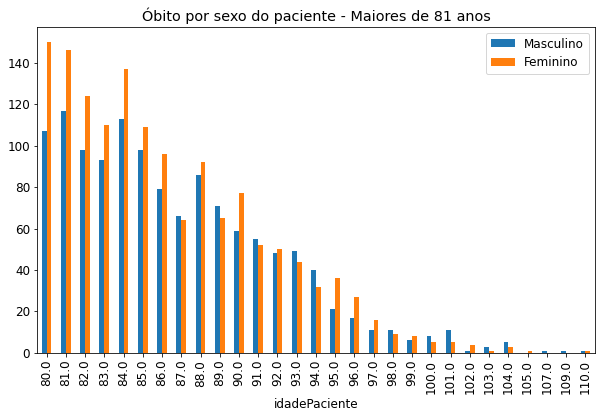

In [71]:
df_obit_faixa9 = df_obitos.loc[ (df_obitos['faixaIdade'] == '80E+')]
df_obit_plot_faixa9 = df_obit_faixa9.groupby(['idadePaciente', 'sexoPaciente']).size().unstack('sexoPaciente')
df_obit_plot_faixa9.columns = ['Masculino', 'Feminino']
df_obit_plot_faixa9.plot.bar(title='Óbito por sexo do paciente - Maiores de 81 anos', figsize=(10,6) )

# **Gerar dataframe somente para a cidade de Fortaleza**

In [ ]:
#df_fortaleza =  df[df['municipioPaciente'] == 'FORTALEZA']

In [ ]:
#df_fortaleza.head(3)

In [ ]:
#df_fortaleza.to_csv ('/content/drive/My Drive/IntegraSUS/casos_FORTALEZA_2020_09_13.csv', index = False, header=True , sep=';' , encoding='UTF-8')

In [ ]:
#df_interior =  df[df['municipioPaciente'] != 'FORTALEZA']

In [ ]:
#df_interior.to_csv ('/content/drive/My Drive/IntegraSUS/casos_INTERIOR_2020_09_13.csv', index = False, header=True , sep=';' , encoding='UTF-8')